In [2]:
# use these magic spells to update your classes methods on-the-fly as you edit them:
%reload_ext autoreload
%autoreload 2
from pprint import pprint
from IPython.core.display import display, HTML, Markdown
import ipywidgets as widgets
# %run includeme.ipynb # include a notebook from this same directory
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_19855/3813857106.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [18]:
# common libs
import math, os, io, json, cv2, random, logging, pickle, datetime
import numpy as np
# torch
import torch
# images
from PIL import Image
import matplotlib.pyplot as plt
# compressai
from compressai.zoo import bmshj2018_factorized

In [4]:
## *** Detectron imports ***
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
# CompressAI-Vision
from compressai_vision.conversion import FO2DetectronDataset # convert fiftyone dataset to Detectron2 dataset
from compressai_vision.conversion import detectron251 # convert Detectron2 results to fiftyone format
from compressai_vision.evaluation.fo import annexPredictions # annex predictions from
from compressai_vision.evaluation.pipeline import CompressAIEncoderDecoder, VTMEncoderDecoder # a class that does encoding+decoding & returns the transformed image & bitrate
from compressai_vision.tools import confLogger, quickLog, getDataFile

In [6]:
# fiftyone
import fiftyone as fo
import fiftyone.zoo as foz

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [8]:
## MODEL A
model_name="COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
## look here:
## https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md#faster-r-cnn
## for the line that says X101-FPN --> box AP is 43

## MODEL B
# model_name="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

In [9]:
# cfg encapsulates the model architecture & weights, also threshold parameter, metadata, etc.
cfg = get_cfg()
cfg.MODEL.DEVICE=device
# load config from a file:
cfg.merge_from_file(model_zoo.get_config_file(model_name))
# DO NOT TOUCH THRESHOLD WHEN DOING EVALUATION:
# too big a threshold will cut the smallest values & affect the precision(recall) curves & evaluation results
# the default value is 0.05
# value of 0.01 saturates the results (they don't change at lower values)
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# get weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)
print("expected input colorspace:", cfg.INPUT.FORMAT)
print("loaded datasets:", cfg.DATASETS)
model_dataset=cfg.DATASETS.TRAIN[0]
print("model was trained with", model_dataset)
model_meta=MetadataCatalog.get(model_dataset)

expected input colorspace: BGR
loaded datasets: PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
PROPOSAL_FILES_TEST: ()
PROPOSAL_FILES_TRAIN: ()
TEST: ('coco_2017_val',)
TRAIN: ('coco_2017_train',)
model was trained with coco_2017_train


In [10]:
# model_meta.thing_classes # check class labels this was trained with

In [11]:
predictor = DefaultPredictor(cfg)

[Checkpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl ...
URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl cached in /home/sampsa/.torch/iopath_cache/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl
Reading a file from 'Detectron2 Model Zoo'


Get a handle to the dataset created in previous notebooks:

In [20]:
dataset = fo.load_dataset("nokia-detection")
# dataset = fo.load_dataset("nokia-detection-dummy") # or use the dummy dataset for testing/debugging

In [13]:
dataset

Name:        nokia-detection-dummy
Media type:  image
Num samples: 1
Persistent:  True
Tags:        []
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    positive_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    negative_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    detections:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    open_images_id:  fiftyone.core.fields.StringField

Set some loglevels

In [14]:
# loglev=logging.DEBUG
loglev=logging.INFO
quickLog("CompressAIEncoderDecoder", loglev)

<Logger CompressAIEncoderDecoder (INFO)>

Get a list of labels in the dataset:

In [15]:
classes = dataset.distinct(
    "detections.detections.label"
)
print(classes)

['airplane']


In [16]:
def per_class(results_obj):
    """helper function: take fiftyone/openimagev6 results object & spit
    out mAP breakdown as per class
    """
    d = {}
    for class_ in classes:
        d[class_] = results_obj.mAP([class_])
    return d

``CompressAIEncoderDecoder`` is a subclass of ``EncoderDecoder``, i.e. it's a class that encodes an image, decodes it, and returns the transformed (encoded+decoded) image and the bitrate of the encoded image.

In particular ``CompressAIEncoderDecoder`` uses a CompressAI encoder/decoder to achieve this.

You used ``annexPredictions`` in the previous notebook to push the dataset through a Detectron2 predictor.  Here, we provide it with an additional parameter: an ``EncoderDecoder`` class that transforms the image before the image is passed to the Detectron2 predictor.

We run the ``bmshj2018_factorized`` model over various quality parameters:

In [ ]:
# params=[1] # debugging
params=[1,2,3,4,5,6,7,8]; 

Detectron prediction results are saved during the run into the fiftyone (mongodb) database.  Let's define a unique name for the sample field where the detectron results are saved:

In [19]:
predictor_field='detectron-{0:%Y-%m-%d-%H-%M-%S-%f}'.format(datetime.datetime.now())
print(predictor_field)

detectron-2022-09-01-17-02-30-310913


In [ ]:
xs=[]; ys=[]; maps=[]; # bpp, mAP values, mAP(s) per class
results=[] # complete results
for i in params:
    net = bmshj2018_factorized(quality=i, pretrained=True).eval().to(device)
    enc_dec = CompressAIEncoderDecoder(net, device=device)
    # note the EncoderDecoder instance here:
    # before the predictor is used, the image is crunched through the encoding/decoding process & the bitrate is recorded
    # you could substitute CompressAIEncoderDecoder with VTMEncoderDecoder if you'd like to (see also the end of this tutorial)
    print("running the detector at", i)
    bpp = annexPredictions(predictor=predictor, fo_dataset=dataset, encoder_decoder=enc_dec, predictor_field=predictor_field)
    # .. now detectron's results are in each sample at the "detectron-predictions"  field
    res = dataset.evaluate_detections(
        predictor_field,
        gt_field="detections",
        method="open-images",
        pos_label_field="positive_labels",
        neg_label_field="negative_labels",
        expand_pred_hierarchy=False,
        expand_gt_hierarchy=False
    )
    results.append((i, bpp, res))
    # save to disk at each iteration as a backup just in case
    xs.append(bpp)
    ys.append(res.mAP())
    maps.append(per_class(res))
    with open("out.json","w") as f:
        json.dump({
            "bpp" : xs, 
            "map" : ys,
            "map_per_class" : maps
            }, f)
print("ready!")

After the evaluation we can (and should!) remove the detectron results from the database:

In [ ]:
dataset.delete_sample_fields(predictor_field)

Load results

In [22]:
with open("out.json","r") as f:
    res=json.load(f)

In [24]:
x=res["bpp"]
y=res["map"]

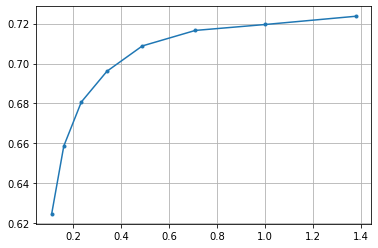

In [22]:
x=np.array(xs); y=np.array(ys)
plt.plot(x,y,'.-')
plt.grid(True)
plt.savefig("out.png")

In that loop over quality parameters above, you cam substitute the ``CompressAIEncoderDecoder`` with ``VTMEncoderDecoder``in order to produce the anchor/baseline results.  Let's first set some variables for the VTM program:

In [7]:
path="/path/to/VVCSoftware_VTM/bin"
vtm_encoder_app=os.path.join(path, "EncoderAppStatic")
vtm_decoder_app=os.path.join(path, "DecoderAppStatic")
vtm_cfg=getDataFile("encoder_intra_vtm_1.cfg")

If you'd want to see what the VTM is doing exactly, enable debugging output:

In [ ]:
loglev=logging.DEBUG
# loglev=logging.INFO
log=quickLog("VTMEncoderDecoder", loglev) # VTMEncoderDecoder

At each quality parameter in the loop, instantiate an ``VTMEncoderDecoder`` instead:

In [ ]:
enc_dec = VTMEncoderDecoder(encoderApp=vtm_encoder_app,
    decoderApp=vtm_decoder_app,
    ffmpeg="ffmpeg",
    vtm_cfg=vtm_cfg,
    qp=47 # # changing value here
)